# Training GCN
Train a Graph Neural Network with the histology + gene information.

We are going to create a brain layer classifier using [Torch Geometric's GCN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html?highlight=gcn#torch-geometric-nn-models-gcn)

## Loading the data

For a detailed exploration and analysis of what the data actually contains, visit the `DataAnalysis` notebook, located in the same directory as this one.

### Downloading the data

In [1]:
%%sh
./dataset/getdata.sh

~/projects/GNNCellClassification/dataset ~/projects/GNNCellClassification
Don't download data: Both data and images exists
~/projects/GNNCellClassification


### Actual loading + preprocessing

In [2]:
import sys, os
sys.path.append(os.path.abspath("src"))

In [3]:
%load_ext autoreload
%autoreload 2
import importlib
import preprocess
import load_data

data_dir, img_dir, graph_dir = "dataset/data", "dataset/images", "out/graphs"
ann_data, histology_imgs = preprocess.main(data_dir, img_dir, graph_dir)

Loading AnnData for sample 151676 …
Loading AnnData for sample 151669 …
Loading AnnData for sample 151507 …
Loading AnnData for sample 151508 …
Loading AnnData for sample 151672 …
Loading AnnData for sample 151670 …
Loading AnnData for sample 151673 …
Loading AnnData for sample 151675 …
Loading AnnData for sample 151510 …
Loading AnnData for sample 151671 …
Loading AnnData for sample 151674 …
Loading AnnData for sample 151509 …
Loading Image for sample 151676 …
Loading Image for sample 151669 …
Loading Image for sample 151507 …
Loading Image for sample 151508 …
Loading Image for sample 151672 …
Loading Image for sample 151670 …
Loading Image for sample 151673 …
Loading Image for sample 151675 …
Loading Image for sample 151510 …
Loading Image for sample 151671 …
Loading Image for sample 151674 …
Loading Image for sample 151509 …


## Features used for training

We are going to use the following features for training:

**Edge Features**:
- Spatial Connectivities` between spots
- Pixel `distance` (adjusted by color)

**Node Features**:
- `UMI` count (log)
- `Color` in the `neighbourhood` of the spot


## PyTorch Geometric's data structure

From the official [Documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html?highlight=gcn#torch-geometric-nn-models-gcn) , we can see that:

A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

- `data.edge_index`: Graph connectivity in `COO` format with shape `[2, num_edges]` and type `torch.long`

- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

## Creating the required data structures for training

We need to convert the data to what's required by PyTorch geometric.

In [4]:
import torch

We randomly select which patients will be used for training, which ones for validation and which ones for testing:

In [5]:
import random



random.seed(42)
train_patients = random.sample(list(ann_data.keys()), 8)
print(f"train_patients: {train_patients}")

rest = [patient for patient in ann_data.keys() if patient not in train_patients]
val_patients = random.sample(rest, 2)
print(f"val_patients: {val_patients}")
test_patients = [patient for patient in rest if patient not in val_patients]
print(f"test_patients: {test_patients}")

train_patients: ['151674', '151669', '151676', '151672', '151508', '151509', '151673', '151671']
val_patients: ['151507', '151675']
test_patients: ['151670', '151510']


### data.edge_index
We need to transform to a `PyTorch` tensor in `COO` format.
Let's start with a reference patient:

In [6]:
ann_data['151676'].obsp['spatial_connectivities']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20052 stored elements and shape (3460, 3460)>

In [7]:
type(ann_data['151676'].obsp['spatial_connectivities'])

scipy.sparse._csr.csr_matrix

In [8]:
coo_matrix = ann_data['151676'].obsp['spatial_connectivities'].tocoo()
coo_matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 20052 stored elements and shape (3460, 3460)>

In [9]:
type(coo_matrix)

scipy.sparse._coo.coo_matrix

In [10]:
coo_connections = { patient: data.obsp['spatial_connectivities'].tocoo()  \
                   for patient, data in ann_data.items() }
for patient, coo in coo_connections.items():
    print(f"Patient {patient}: {coo.shape}")

Patient 151676: (3460, 3460)
Patient 151669: (3661, 3661)
Patient 151507: (4226, 4226)
Patient 151508: (4384, 4384)
Patient 151672: (4015, 4015)
Patient 151670: (3498, 3498)
Patient 151673: (3639, 3639)
Patient 151675: (3592, 3592)
Patient 151510: (4634, 4634)
Patient 151671: (4110, 4110)
Patient 151674: (3673, 3673)
Patient 151509: (4789, 4789)


In [11]:
edge_indices = {}

for patient, coo in coo_connections.items():
    row = torch.from_numpy(coo.row).long()
    col = torch.from_numpy(coo.col).long()
    edge_indices[patient] = torch.stack([row, col], dim=0)

    print(f"{patient}: {edge_indices[patient].shape}")

151676: torch.Size([2, 20052])
151669: torch.Size([2, 21194])
151507: torch.Size([2, 24770])
151508: torch.Size([2, 25698])
151672: torch.Size([2, 23382])
151670: torch.Size([2, 20370])
151673: torch.Size([2, 21124])
151675: torch.Size([2, 20762])
151510: torch.Size([2, 27198])
151671: torch.Size([2, 24052])
151674: torch.Size([2, 21258])
151509: torch.Size([2, 28172])


### data.edge_attr
Edge feature matrix with shape `[num_edges, num_edge_features]`.
For now, only get the distances for the ones that are spatially connected.

In [12]:
import numpy as np
import os

edge_features = {}
for patient in ann_data.keys():
    filename = str(f"{patient}_adj.npy")
    adj_distances = np.load(os.path.join(graph_dir, filename))
    adj_tensor = torch.from_numpy(adj_distances)
    row, col = edge_indices[patient]
    distances = adj_tensor[row, col]
    edge_features[patient] = distances.unsqueeze(1).float()
    print(f"{patient}: {edge_features[patient].shape}")

151676: torch.Size([20052, 1])
151669: torch.Size([21194, 1])
151507: torch.Size([24770, 1])
151508: torch.Size([25698, 1])
151672: torch.Size([23382, 1])
151670: torch.Size([20370, 1])
151673: torch.Size([21124, 1])
151675: torch.Size([20762, 1])
151510: torch.Size([27198, 1])
151671: torch.Size([24052, 1])
151674: torch.Size([21258, 1])
151509: torch.Size([28172, 1])


### data.x
Node feature matrix with shape `[num_nodes, num_node_features]`

#### Normalizing UMI count data

In [13]:
import scanpy as sc

normalized_data = {}
for patient in ann_data.keys():
    sc.pp.normalize_total(ann_data[patient])
    sc.pp.log1p(ann_data[patient])
    normalized_data[patient] = ann_data[patient].X

#### Reducing Dimensionality of data.x
Apply `PCA` Principal Component Analysis on the gene expression count to reduce the dimensionality of the data.

In [14]:
from scipy.sparse import vstack
from sklearn.decomposition import TruncatedSVD


train_data = list(data for patient, data in normalized_data.items() if patient in train_patients)
assert len(train_data) == 8
train_stack = vstack(list(train_data))
# svd.components_ now holds a shared basis between all the spots in the training set.
# This basis will be freezed for using it when validating and testing.
svd = TruncatedSVD(n_components=50, random_state=0)
svd.fit(train_stack)

reduced_data = {patient: svd.transform(X) for patient, X in normalized_data.items()}
for data in reduced_data.values():
    print(data.shape)

(3460, 50)
(3661, 50)
(4226, 50)
(4384, 50)
(4015, 50)
(3498, 50)
(3639, 50)
(3592, 50)
(4634, 50)
(4110, 50)
(3673, 50)
(4789, 50)


#### Retrieving histology color information for data.x
Add it to the data.x matrix as an extra feature.

In [15]:
from graph import get_region_colors

offsets = {'151676': 310, '151669': 276, '151507': 236, '151508': 232, '151672': 264, \
        '151670': 339, '151673': 260, '151675': 228, '151510': 204, '151671': 238, \
        '151674': 234, '151509': 220}
thickness = 48

normalized_color_avgs = {}
for patient_id, data in ann_data.items():
    offset = offsets[patient_id]
    hires_scale = ann_data[patient_id].uns['spatial'][patient_id]['scalefactors']['tissue_hires_scalef']
    spot_pixels = ann_data[patient_id].obsm['spatial'] * hires_scale
    spot_pixels = spot_pixels.astype(int)
    
    image = ann_data[patient_id].uns['spatial'][patient_id]['images']['hires']
    hires_shape = image.shape
    assert min(hires_shape[0], hires_shape[1]) > spot_pixels.max()

    flipped_image = np.flip(image, 0)
    x_pixels = spot_pixels[:, 0]
    y_pixels = spot_pixels[:, 1]
    
    normalized_color_avgs[patient_id] = get_region_colors(x_pixels, y_pixels, offset=offsets[patient_id], image=flipped_image, thickness=thickness, alpha=1)
    print(normalized_color_avgs[patient_id].shape)

Variances of color0, color1, color2 =  [0.00134047 0.00493318 0.00063244]
(3460,)
Variances of color0, color1, color2 =  [0.00100299 0.00408081 0.00090281]
(3661,)
Variances of color0, color1, color2 =  [0.00058533 0.00256631 0.00049386]
(4226,)
Variances of color0, color1, color2 =  [0.00059817 0.00289116 0.00048598]
(4384,)
Variances of color0, color1, color2 =  [0.00160404 0.00482472 0.00077629]
(4015,)
Variances of color0, color1, color2 =  [0.00137143 0.00389194 0.00066271]
(3498,)
Variances of color0, color1, color2 =  [0.00084196 0.00644021 0.00071149]
(3639,)
Variances of color0, color1, color2 =  [0.00166604 0.00636242 0.00100769]
(3592,)
Variances of color0, color1, color2 =  [0.00063251 0.00230641 0.00054535]
(4634,)
Variances of color0, color1, color2 =  [0.00228128 0.00711623 0.00111823]
(4110,)
Variances of color0, color1, color2 =  [0.00123189 0.00723225 0.00067618]
(3673,)
Variances of color0, color1, color2 =  [0.00053539 0.00314728 0.00054947]
(4789,)


#### Integrating UMI count + color information
Integrate the normalized and dimensionality-reduced `UMI` count information with the `color` information to form the data.x matrix.

In [16]:
import torch
import numpy as np
from torch_geometric.data import Data

data_x = {}
for patient_id, data in ann_data.items():
    pca = reduced_data[patient_id]
    color_avgs = normalized_color_avgs[patient_id]
    color_avgs = color_avgs.reshape(-1, 1)
    x_np = np.hstack([pca, color_avgs])
    
    x_tensor = torch.from_numpy(x_np).float()
    
    data_x[patient_id] = x_tensor
    print(data_x[patient_id].shape)

torch.Size([3460, 51])
torch.Size([3661, 51])
torch.Size([4226, 51])
torch.Size([4384, 51])
torch.Size([4015, 51])
torch.Size([3498, 51])
torch.Size([3639, 51])
torch.Size([3592, 51])
torch.Size([4634, 51])
torch.Size([4110, 51])
torch.Size([3673, 51])
torch.Size([4789, 51])


### data.y
Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

In our case, the target is the brian layer for each node, so it's going to be of shape [num_nodes, 1]

As each brain layer category is a string, we should use their values to get a tensor out of them instead. This can be easily done in AnnData:

- `Layer 1` -> `0`
- `Layer 2` -> `1`
- `Layer 3` -> `2`
- `Layer 4` -> `3`
- `Layer 5` -> `4`
- `Layer 6` -> `5`
- `Layer WM` -> `6`

In [17]:
print("layer categories:" , ann_data['151676'].obs["sce.layer_guess"].head(4))
print("--------")
print("layer codes:" , ann_data['151676'].obs["sce.layer_guess"].cat.codes.head(4))

layer categories: AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
Name: sce.layer_guess, dtype: category
Categories (7, object): ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']
--------
layer codes: AAACAAGTATCTCCCA-1    2
AAACAATCTACTAGCA-1    0
AAACACCAATAACTGC-1    6
AAACAGAGCGACTCCT-1    2
dtype: int8


There are a few NaN s in the dataset. Convert them to a new layer for now.

In [18]:
data_y = {}
for patient_id, data in ann_data.items():
    print("patient_id:", patient_id)
    codes = data.obs["sce.layer_guess"].cat.codes.values.copy()
    codes[codes == -1] = max(codes) + 1

    data_y[patient_id] = torch.tensor(codes, dtype=torch.long)

    print(data_y[patient_id])


patient_id: 151676
tensor([2, 0, 6,  ..., 6, 5, 0])
patient_id: 151669
tensor([1, 3, 0,  ..., 3, 2, 0])
patient_id: 151507
tensor([0, 2, 0,  ..., 6, 5, 0])
patient_id: 151508
tensor([2, 0, 6,  ..., 4, 6, 0])
patient_id: 151672
tensor([2, 3, 0,  ..., 3, 3, 0])
patient_id: 151670
tensor([1, 3, 0,  ..., 3, 2, 0])
patient_id: 151673
tensor([2, 0, 6,  ..., 5, 6, 1])
patient_id: 151675
tensor([0, 2, 6,  ..., 6, 5, 6])
patient_id: 151510
tensor([0, 4, 2,  ..., 2, 5, 2])
patient_id: 151671
tensor([2, 3, 0,  ..., 2, 4, 0])
patient_id: 151674
tensor([2, 0, 6,  ..., 5, 6, 0])
patient_id: 151509
tensor([0, 2, 5,  ..., 3, 5, 1])


## data.pos
Node position matrix with shape [num_nodes, num_dimensions]

In [19]:
data_pos = {}

for patient_id, data in ann_data.items():
    y_tensor = torch.from_numpy(data.obs[['array_row', 'array_col']].values)
    y_tensor = y_tensor.to(torch.int16)
    data_pos[patient_id] = y_tensor
    print(data_pos[patient_id].shape)

torch.Size([3460, 2])
torch.Size([3661, 2])
torch.Size([4226, 2])
torch.Size([4384, 2])
torch.Size([4015, 2])
torch.Size([3498, 2])
torch.Size([3639, 2])
torch.Size([3592, 2])
torch.Size([4634, 2])
torch.Size([4110, 2])
torch.Size([3673, 2])
torch.Size([4789, 2])


## Creating the Data Loaders with all the gathered information
One for each group:
- Training
- Validation
- Testing

In [20]:
from torch_geometric.loader import DataLoader

train_datalist = []
val_datalist = []
test_datalist = []

for patient_id in ann_data.keys():
    curr_data = Data(
        x=data_x[patient_id],
        edge_index=edge_indices[patient_id],
        edge_attr=edge_features[patient_id],
        pos=data_pos[patient_id],
        y=data_y[patient_id]
    )
    if patient_id in train_patients:
        train_datalist.append(curr_data)
    elif patient_id in val_patients:
        val_datalist.append(curr_data)
    elif patient_id in test_patients:
        test_datalist.append(curr_data)
    else:
        raise Exception("patient doesn't belong to neither training, validation nor test groups")

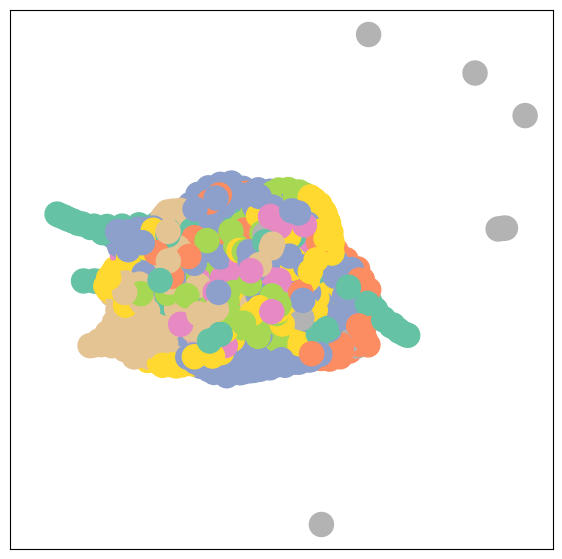

In [21]:
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import networkx as nx


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
    

G = to_networkx(train_datalist[0], to_undirected=True)
visualize_graph(G, color=train_datalist[0].y)

In [22]:
import yaml

# Hyperparameters set in `params.yaml`
params = yaml.safe_load(open("params.yaml"))['train']
batch_size = params['batch_size']

train_loader = DataLoader(dataset=train_datalist, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_datalist, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_datalist, batch_size=batch_size, shuffle=False)

## Import Model

In [23]:
from model import GNNClassifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNClassifier().to(device)

## Optimizer, Loss and Scheduler

In [24]:
from torch import nn
from torch import optim

learning_rate = params['learning_rate']
weight_decay = float(params['weight_decay'])

num_epochs = params['num_epochs']

optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

## Training

In [27]:
%load_ext autoreload
%autoreload 2
from train import train_loop

loaders = (train_loader, val_loader)
train_loop(model, optimizer, criterion, scheduler, loaders, device, num_epochs, params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loop
epoch:  1
Epoch 001 : Loss: 2.6341 | Val Loss: 2.3139 | Val Acc: 0.1572
epoch:  2
Epoch 002 : Loss: 2.4410 | Val Loss: 2.2638 | Val Acc: 0.1624
🏃 View run unequaled-hawk-443 at: http://localhost:5000/#/experiments/2/runs/76f218b8f8274f8890442558fb1a1357
🧪 View experiment at: http://localhost:5000/#/experiments/2
